### 1 Consulta SQL que retorna o ganho total da empresa por cliente

In [105]:
with valor_liquido as (
    select
        cliente.nome as cliente_nome,
        sum((transacao.valor_total-((transacao.valor_total * coalesce(transacao.percentual_desconto, 0))/100))) as valor_total,
        contrato.percentual as percentual
    from transacao
    left join contrato
    on transacao.contrato_id = contrato.contrato_id
    left join cliente on contrato.cliente_id = cliente.cliente_id
    where ativo is true
    group by cliente_nome, percentual
)

select
    cliente_nome,
    (valor_total * percentual)/100 as valor
from valor_liquido
group by cliente_nome, valor

--------------------------------------------

In [8]:
from pyspark.sql.functions import sum
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode

spark = SparkSession.builder.master("local").appName("desafio_tecnico").getOrCreate()
dataFrame = spark.read.option("multiline", "true").json("data.json")

### 2 Código para retornar o total líquido

In [9]:
transacoes = [
    {'transacao_id':1, 'total_bruto':3000, 'desconto_percentual':6.99},
    {'transacao_id':2, 'total_bruto':57989, 'desconto_percentual':1.45},
    {'transacao_id':4, 'total_bruto':1, 'desconto_percentual':None},
    {'transacao_id':5, 'total_bruto':34, 'desconto_percentual':0.0},
]
df = spark.createDataFrame(transacoes).na.fill(0)
df.show()
# total_bruto = df.select('total_bruto')
# desconto_percentual = df.select('desconto_percentual')
# test = total_bruto+1
# test.show()
# total_liquido = total_bruto - ((total_bruto. desconto_percentual)/100)
# desconto_percentual.show()

+-------------------+-----------+------------+
|desconto_percentual|total_bruto|transacao_id|
+-------------------+-----------+------------+
|               6.99|       3000|           1|
|               1.45|      57989|           2|
|                0.0|          1|           4|
|                0.0|         34|           5|
+-------------------+-----------+------------+



### 3.1 Expansão da coluna ItemList

In [17]:
dataFrameExploded = dataFrame.select("CreateDate","EmissionDate","Discount","NFeNumber","NFeID", explode("ItemList")).withColumnRenamed("col", "Item")
dataFrameCombined = dataFrameExploded.select("CreateDate","EmissionDate","Discount","NFeNumber","NFeID","Item.*")
dataFrameCombined.show()

+--------------------+-------------------+--------+---------+-----+------------+--------+-----+
|          CreateDate|       EmissionDate|Discount|NFeNumber|NFeID| ProductName|Quantity|Value|
+--------------------+-------------------+--------+---------+-----+------------+--------+-----+
|2021-05-24T20:21:...|2021-05-24T00:00:00|     0.0|      501|    1|        Rice|       2|35.55|
|2021-05-24T20:21:...|2021-05-24T00:00:00|     0.0|      501|    1|       Flour|       5|11.55|
|2021-05-24T20:21:...|2021-05-24T00:00:00|     0.0|      501|    1|        Bean|       7|27.15|
|2021-05-24T20:21:...|2021-05-24T00:00:00|     0.0|      502|    2|      Tomate|      10|12.25|
|2021-05-24T20:21:...|2021-05-24T00:00:00|     0.0|      502|    2|       Pasta|       5| 7.55|
|2021-05-24T20:21:...|2021-05-24T00:00:00|     0.0|      503|    3|        Beer|       6|  9.0|
|2021-05-24T20:21:...|2021-05-24T00:00:00|     0.0|      503|    3|French fries|       2|10.99|
|2021-05-24T20:21:...|2021-05-24T00:00:0

### 3.2 Separação da conluna ItemList em um dataframe separado

In [71]:
items = dataFrameExploded.select("Item.ProductName", "Item.Value", "Item.Quantity")
items = items.withColumn("Value",items['Value']/items['Quantity'])

from pyspark.sql.functions import round

items = items.withColumn("Value", round(items['Value'], 2))
dataFrameItems = items.select(items.ProductName, items.Value)
dataFrameItems.show()

+------------+-----+
| ProductName|Value|
+------------+-----+
|        Rice|17.78|
|       Flour| 2.31|
|        Bean| 3.88|
|      Tomate| 1.23|
|       Pasta| 1.51|
|        Beer|  1.5|
|French fries|  5.5|
|   Ice cream|27.15|
+------------+-----+



### 4 Arquitetura exemplo de ingestão

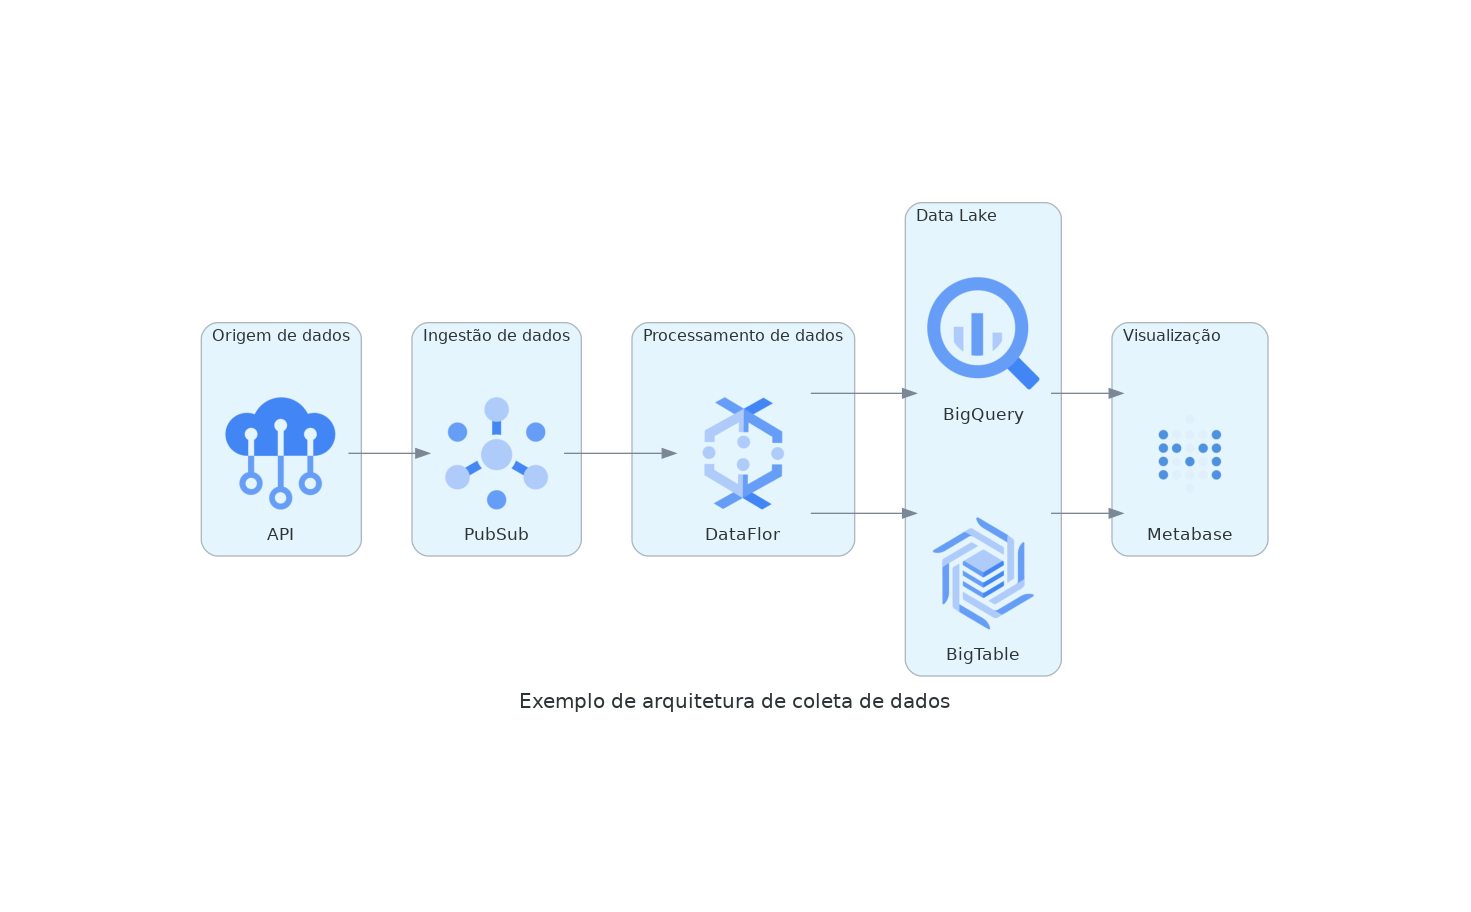

In [5]:
"""
- Exemplo de arquitetura de coleta de dados

Utilizaria a ferramenta PubSub para a ingestão dos dados oriundos
da API de nota fiscal via tópicos, para que pudessem ser carregados
no DataFlow e serem realizadas transformações e limpezas possibilitando
a carga para o BigQuery ou BigTable onde poderiam ser utilizados
pelos times de análise de dados ou até mesmo o de ciência de dados,
além de existir a possibilidade de conectar ferramentas de visualização
de dados como o Metabase.
"""
from diagrams import Cluster, Diagram
from diagrams.gcp.analytics import BigQuery, Dataflow, PubSub
from diagrams.gcp.database import BigTable
from diagrams.gcp.iot import IotCore
from diagrams.onprem.analytics import Metabase

with Diagram("Exemplo de arquitetura de coleta de dados", show=False) as diagram:
    with Cluster("Origem de dados"):
         api = IotCore("API")

    with Cluster("Ingestão de dados"):
        pubsub = PubSub("PubSub")

    with Cluster("Processamento de dados"):
        flow = Dataflow("DataFlor")

    with Cluster("Data Lake"):
        data_lake = [BigQuery("BigQuery"),
                    BigTable("BigTable")]

    with Cluster("Visualização"):
        data_viz = Metabase("Metabase")

    api >> pubsub
    pubsub >> flow
    flow >> data_lake
    data_lake >> data_viz

diagram